In [3]:
# importing package
import pandas as pd
import numpy as np
import joblib
import plydata.cat_tools as cat
import plotnine as pn

pn.options.dpi=300
# from xgboost import XBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV

In [4]:
# !pip install plydata

In [5]:
#!pip install plotnine

# 1. Data Preparation

In [55]:
raw_data = pd.read_csv('CDNOW_master.txt',sep='\s+',names=['customer_id','date','quantity','price'])
raw_data

,customer_id,date,quantity,price
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76
...,...,...,...,...
69654,23568,19970405,4,83.74
69655,23568,19970422,1,14.99
69656,23569,19970325,2,25.74
69657,23570,19970325,3,51.12


In [56]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  int64  
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


In [57]:
raw_data.isnull().sum()

customer_id    0
date           0
quantity       0
price          0
dtype: int64

In [58]:
type(raw_data['date'])

pandas.core.series.Series

In [59]:
raw_data['date'] = raw_data['date'].astype('str') #converting to string 
raw_data['date'] = pd.to_datetime(raw_data['date'],format='%Y%m%d') # converting into datetime

In [47]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   cstomer_id  69659 non-null  int64         
 1   date        69659 non-null  datetime64[ns]
 2   quantity    69659 non-null  int64         
 3   price       69659 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.1 MB


## 2. Cohort Analysis

In [64]:
# taking first occuarnce of customer

first_purchase = raw_data.sort_values(by=['customer_id','date']).groupby(['customer_id']).first()
print(first_purchase)

                  date  quantity  price
customer_id                            
1           1997-01-01         1  11.77
2           1997-01-12         1  12.00
3           1997-01-02         2  20.76
4           1997-01-01         2  29.33
5           1997-01-01         2  29.33
...                ...       ...    ...
23566       1997-03-25         2  36.00
23567       1997-03-25         1  20.97
23568       1997-03-25         1  22.97
23569       1997-03-25         2  25.74
23570       1997-03-25         3  51.12

[23570 rows x 3 columns]


In [81]:
# finding min and max day
min_day = raw_data['date'].min()
print('min_day : ',min_day)

max_day = raw_data['date'].max()
print('max_day : ',max_day)

totalday = max_day- min_day
print("totalday : ",totalday)
print(int(totalday/np.timedelta64(1,'M'))) #in month

min_day :  1997-01-01 00:00:00
max_day :  1998-06-30 00:00:00
totalday :  545 days 00:00:00
17


### Visualize all purchase

<AxesSubplot:xlabel='date'>

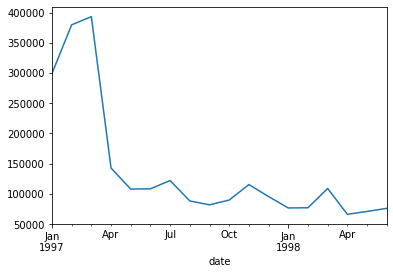

In [109]:
raw_data.reset_index().set_index('date')['price'].resample(rule="MS").sum().plot()
# clear index reset_index
# set index as date - set_index('date')
# need only price - ['price']
# based on month grouping - resample(rule="MS")
# sum() adding amount - sum()
# plot - plot()

### Visualize individual customer purchase

In [132]:
unique_id = raw_data['customer_id'].unique() # picking unique ID
ids_selected = unique_id[0:10] #selectig 10 id

#subset of unique customer purchase details
subset_raw_data = raw_data[raw_data['customer_id'].isin(ids_selected)].groupby(['customer_id','date']).sum().reset_index()
subset_raw_data

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,6,89.00
2,3,1997-01-02,2,20.76
3,3,1997-03-30,2,20.76
4,3,1997-04-02,2,19.54
5,3,1997-11-15,5,57.45
6,3,1997-11-25,4,20.96
7,3,1998-05-28,1,16.99
8,4,1997-01-01,2,29.33
9,4,1997-01-18,2,29.73


C:\Users\admin\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
C:\Users\admin\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
C:\Users\admin\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


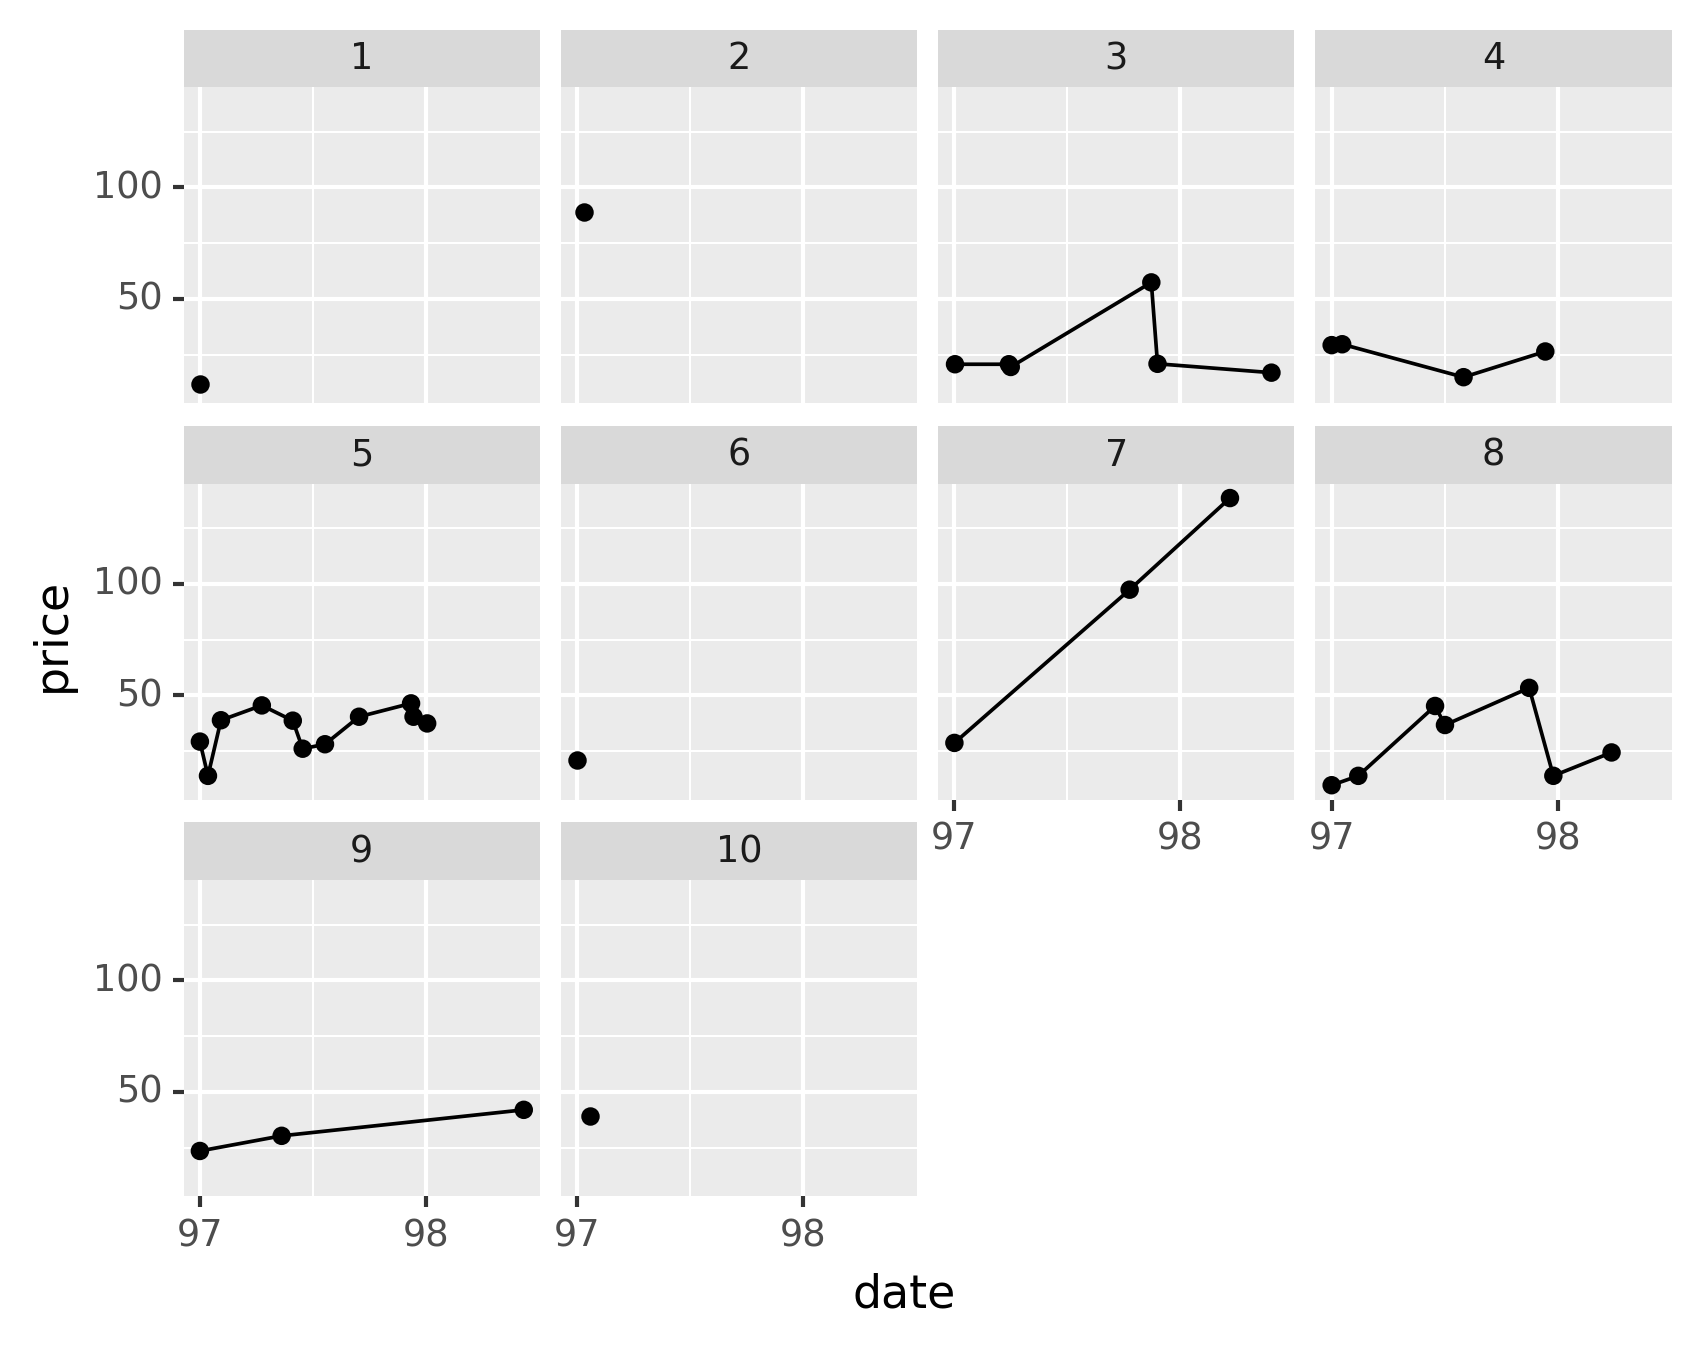

<ggplot: (148026154180)>

In [298]:
# ploting customer purchase detailas
pn.ggplot(subset_raw_data,aes("date","price",group='customer_id'))+pn.geom_line()+pn.geom_point()+pn.facet_wrap('customer_id')+pn.scale_x_date(date_breaks="1 year",date_labels='%y')


## 3. Machine Learning
#### Frame the problem:
###### 1.what will the customer spent in next 90 days (Regression)
###### 2.What is the probability of customer to make purchase in next 90 days?

In [168]:
# Time split

n_days = 90
max_day = raw_data['date'].max()
cutoff_day = max_day - pd.to_timedelta(n_days,unit='d')
print(cutoff_day)

temporal_in_df = raw_data[raw_data['date'] <= cutoff_day]
temporal_out_df = raw_data[raw_data['date'] > cutoff_day]
print(temporal_in_df)
print(temporal_out_df)

1998-04-01 00:00:00
       customer_id       date  quantity  price
0                1 1997-01-01         1  11.77
1                2 1997-01-12         1  12.00
2                2 1997-01-12         5  77.00
3                3 1997-01-02         2  20.76
4                3 1997-03-30         2  20.76
...            ...        ...       ...    ...
69654        23568 1997-04-05         4  83.74
69655        23568 1997-04-22         1  14.99
69656        23569 1997-03-25         2  25.74
69657        23570 1997-03-25         3  51.12
69658        23570 1997-03-26         2  42.96

[63799 rows x 4 columns]
       customer_id       date  quantity  price
8                3 1998-05-28         1  16.99
38               9 1998-06-08         2  41.98
68              25 1998-04-17         1  12.99
69              25 1998-05-25         1  10.49
70              25 1998-06-03         3  24.97
...            ...        ...       ...    ...
69583        23534 1998-05-02         1  10.48
69623        2

In [180]:
# make target from out data

target_df = temporal_out_df.drop(['quantity'],axis=1).groupby(['customer_id']).sum().rename({'price':"spent_90_days"},axis=1).assign(spent_90_flag=1)
target_df

,spent_90_days,spent_90_flag
customer_id,,
3,16.99,1
9,41.98,1
25,73.43,1
29,48.45,1
31,117.99,1
...,...,...
23529,40.56,1
23534,10.48,1
23555,77.44,1


In [200]:
# create Recency feature

max_day = temporal_in_df['date'].max()
print("max day = ",max_day)
recency_df = temporal_in_df[['customer_id','date']].groupby('customer_id').apply(lambda x : (x['date'].max() - max_day) / pd.to_timedelta(1,'day')).to_frame().set_axis(['recency'],axis=1)
recency_df


max day =  1998-04-01 00:00:00


,recency
customer_id,
1,-455.0
2,-444.0
3,-127.0
4,-110.0
5,-88.0
...,...
23566,-372.0
23567,-372.0
23568,-344.0


In [206]:
# create frequency feature

frequency_df = temporal_in_df[['customer_id','date']].groupby('customer_id').count().set_axis(['fequency'],axis=1)
frequency_df

,fequency
customer_id,
1,1
2,2
3,5
4,4
5,11
...,...
23566,1
23567,1
23568,3


In [213]:
# create Monetory feature

monetory_df = temporal_in_df[['customer_id','price']].groupby('customer_id').aggregate({'price':{'sum','mean'}}).set_axis(['price_sum','price_mean'],axis=1)
monetory_df

,price_sum,price_mean
customer_id,,
1,11.77,11.770000
2,89.00,44.500000
3,139.47,27.894000
4,100.50,25.125000
5,385.61,35.055455
...,...,...
23566,36.00,36.000000
23567,20.97,20.970000
23568,121.70,40.566667


In [222]:
# combine features

feature_df = pd.concat([recency_df,frequency_df,monetory_df],axis=1).merge(
target_df,
left_index=True,
right_index=True,
how='left').fillna(0)


feature_df

,recency,fequency,price_sum,price_mean,spent_90_days,spent_90_flag
customer_id,,,,,,
1,-455.0,1,11.77,11.770000,0.00,0.0
2,-444.0,2,89.00,44.500000,0.00,0.0
3,-127.0,5,139.47,27.894000,16.99,1.0
4,-110.0,4,100.50,25.125000,0.00,0.0
5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...
23566,-372.0,1,36.00,36.000000,0.00,0.0
23567,-372.0,1,20.97,20.970000,0.00,0.0
23568,-344.0,3,121.70,40.566667,0.00,0.0


In [224]:
#!pip install xgboost

  Using cached xgboost-1.6.1-py3-none-win_amd64.whl (125.4 MB)


  ## 4. Machine Learning

### i.Regression Model

In [228]:
from xgboost import XGBClassifier,XGBRegressor
from sklearn.model_selection import GridSearchCV

In [240]:
# spent next 90 days prediction

X = feature_df[['recency','fequency','price_sum','price_mean']]
y_spend = feature_df[['spent_90_days']]

#define reg spec
xgb_reg_spec = XGBRegressor(objective="reg:squarederror",random_state=123)

# model build
xgb_reg_model = GridSearchCV(estimator=xgb_reg_spec , param_grid=dict(learning_rate=[0.01,0.1,0.3,0.5]),
                             scoring='neg_mean_absolute_error',
                            refit=True,
                            cv=5)


In [241]:
# model trining
xgb_reg_model.fit(X,y_spend) 

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,


In [247]:
print(xgb_reg_model.best_score_)
print(xgb_reg_model.best_params_)
print(xgb_reg_model.best_estimator_)

-9.798940736745038
{'learning_rate': 0.01}
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, ...)


In [248]:
prediction_reg = xgb_reg_model.predict(X)
prediction_reg

array([0.76148176, 1.7241197 , 8.92676   , ..., 3.2925851 , 0.8648808 ,
       2.1359034 ], dtype=float32)

### ii.Classification Model

In [258]:
#define clssifi output
y_prob = feature_df[['spent_90_flag']]

# define model spec
xgb_cla_spc = XGBClassifier(objective='binary:logistic',random_state=123)

#define model
xgb_cla_model = GridSearchCV(estimator = xgb_cla_spc, param_grid=dict(learning_rate=[0.01,0.1,0.3,0.5]),scoring='roc_auc',refit=True,cv=5)

In [259]:
xgb_cla_model.fit(X,y_prob)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
    

In [260]:
print(xgb_cla_model.best_score_)
print(xgb_cla_model.best_params_)
print(xgb_cla_model.best_estimator_)

0.8356414015855862
{'learning_rate': 0.01}
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, ...)


In [264]:
prediction_claf = xgb_cla_model.predict_proba(X)
prediction_claf

array([[0.79955226, 0.20044775],
       [0.7899691 , 0.21003091],
       [0.6595424 , 0.34045762],
       ...,
       [0.7621703 , 0.23782966],
       [0.7955098 , 0.20449017],
       [0.77555573, 0.22444427]], dtype=float32)

## Feature Importances

In [300]:
# Imporatnace | Spent Amount model
imp_amnt_spent_dict = xgb_reg_model.best_estimator_.get_booster().get_score(importance_type='gain')
print(imp_amnt_spent_dict)

imporatnace_xgb_reg_model_df = pd.DataFrame(
    data={
    'feature':list(imp_amnt_spent_dict.keys()),
    'values':list(imp_amnt_spent_dict.values())
}).assign(feature = lambda x : cat.cat_reorder(x['feature'],x['values']))
print(imporatnace_xgb_reg_model_df)

{'recency': 161406.828125, 'fequency': 149994.78125, 'price_sum': 636200.0625, 'price_mean': 34036.61328125}
      feature         values
0     recency  161406.828125
1    fequency  149994.781250
2   price_sum  636200.062500
3  price_mean   34036.613281


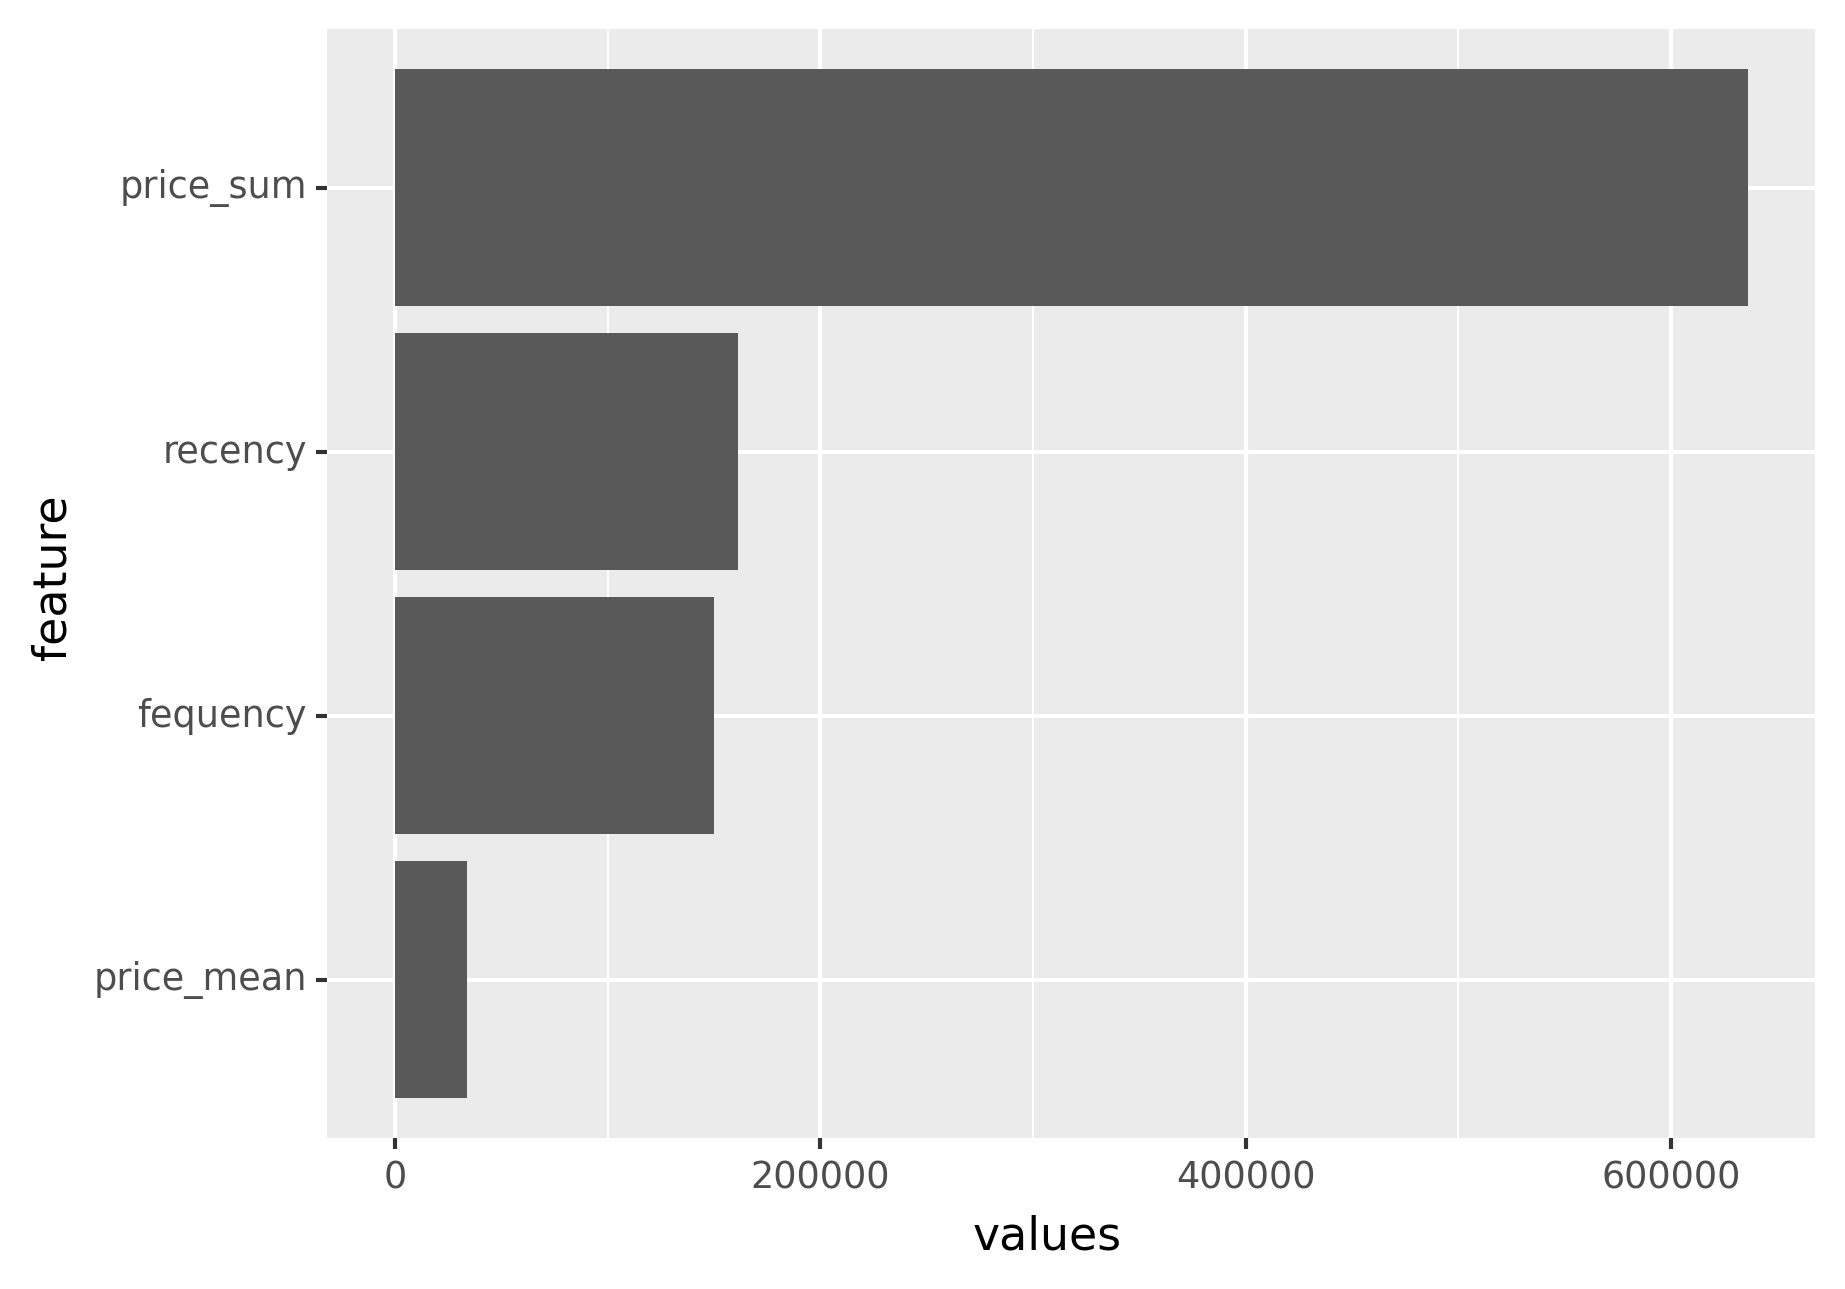

<ggplot: (148025400899)>

In [301]:
# from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
# from plotnine.data import mtcars
ggplot(imporatnace_xgb_reg_model_df,aes('feature','values'))+pn.geom_col()+pn.coord_flip()

In [304]:
# Imporatnace | Spent Amount model
imp_amnt_proba_dict = xgb_cla_model.best_estimator_.get_booster().get_score(importance_type='gain')
print(imp_amnt_spent_dict)

imporatnace_xgb_cla_model_df = pd.DataFrame(
    data={
    'feature':list(imp_amnt_proba_dict.keys()),
    'values':list(imp_amnt_proba_dict.values())
}).assign(feature = lambda x : cat.cat_reorder(x['feature'],x['values']))
print(imporatnace_xgb_cla_model_df)

{'recency': 73.8354263305664, 'fequency': 55.644554138183594, 'price_sum': 2.9522976875305176, 'price_mean': 3.2437374591827393}
      feature     values
0     recency  73.835426
1    fequency  55.644554
2   price_sum   2.952298
3  price_mean   3.243737


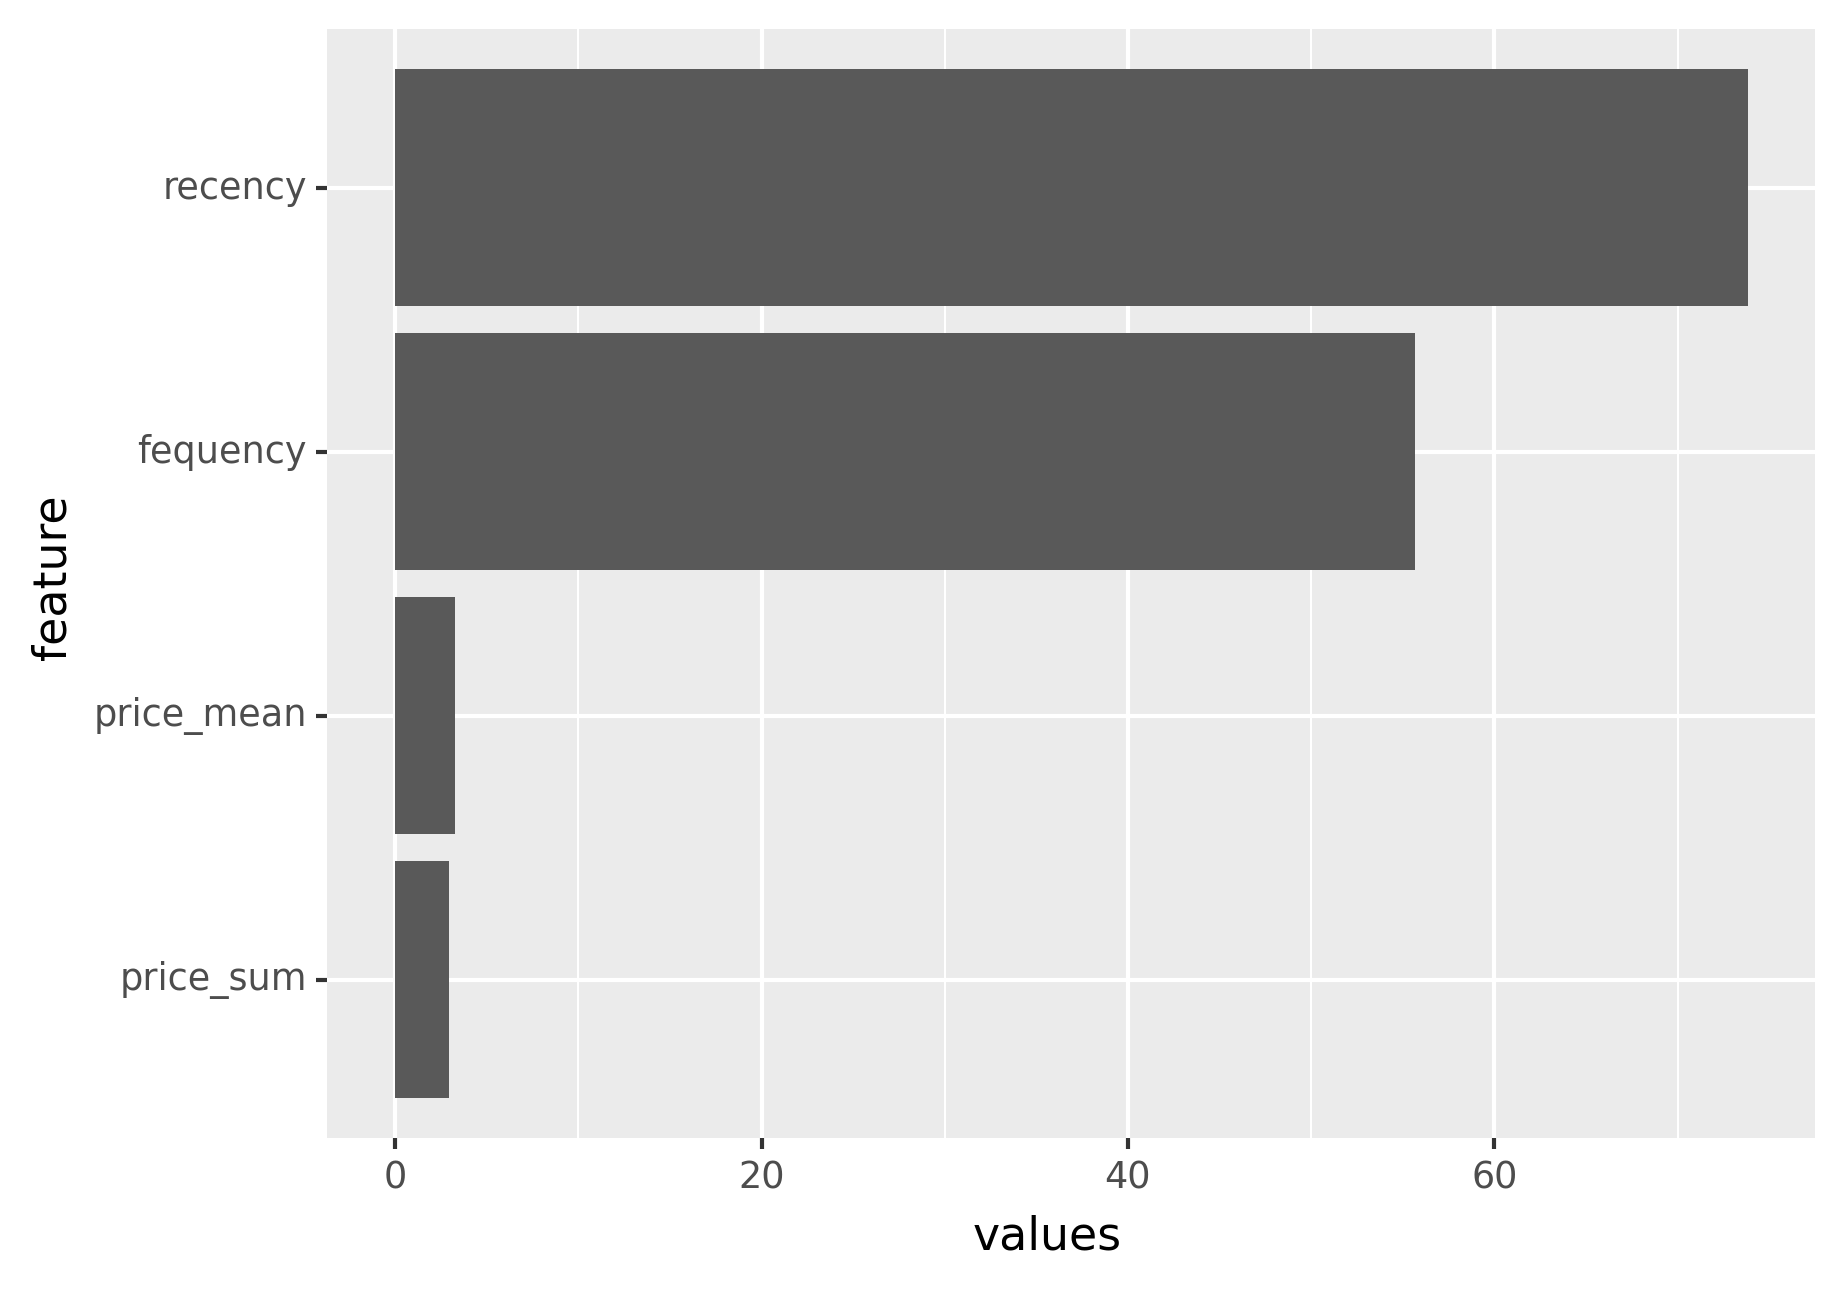

<ggplot: (148028892947)>

In [306]:
# from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
# from plotnine.data import mtcars
ggplot(imporatnace_xgb_reg_model_df,aes('feature','values'))+pn.geom_col()+pn.coord_flip()

## Save work

In [313]:
# prediction saved into csv file
prediction_df = pd.concat([pd.DataFrame(prediction_reg).set_axis(['Pred_spent'],axis=1),pd.DataFrame(prediction_claf)[[1]].set_axis(['Pred_prob'],axis=1),feature_df.reset_index()],axis=1)
prediction_df
prediction_df.to_csv('Predition_output.csv')
prediction_df.to_pickle('artifacts/prediction_df.pkl')

# read
temp = pd.read_pickle('artifacts/prediction_df.pkl')
temp

,Pred_spent,Pred_prob,customer_id,recency,fequency,price_sum,price_mean,spent_90_days,spent_90_flag
0,0.761482,0.200448,1,-455.0,1,11.77,11.770000,0.00,0.0
1,1.724120,0.210031,2,-444.0,2,89.00,44.500000,0.00,0.0
2,8.926760,0.340458,3,-127.0,5,139.47,27.894000,16.99,1.0
3,7.594741,0.340458,4,-110.0,4,100.50,25.125000,0.00,0.0
4,16.058043,0.552980,5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...,...,...,...
23565,0.864881,0.204490,23566,-372.0,1,36.00,36.000000,0.00,0.0
23566,0.864881,0.204490,23567,-372.0,1,20.97,20.970000,0.00,0.0
23567,3.292585,0.237830,23568,-344.0,3,121.70,40.566667,0.00,0.0
23568,0.864881,0.204490,23569,-372.0,1,25.74,25.740000,0.00,0.0


In [314]:
# save imporatnce
imporatnace_xgb_cla_model_df.to_pickle('artifacts/imporatnace_xgb_cla_model_df.pkl')
imporatnace_xgb_reg_model_df.to_pickle('artifacts/imporatnace_xgb_reg_model_df.pkl')

In [316]:
#save model
joblib.dump(xgb_reg_model,'artifacts/xgb_reg_model.pkl')
joblib.dump(xgb_cla_model,'artifacts/xgb_cla_model.pkl')

#load model
model = joblib.load('artifacts/xgb_reg_model.pkl')
model.predict(X)

array([0.76148176, 1.7241197 , 8.92676   , ..., 3.2925851 , 0.8648808 ,
       2.1359034 ], dtype=float32)

In [334]:
# which customer have highest probality to spent in next 90 days

prediction_df.sort_values('Pred_prob',ascending=False)

,Pred_spent,Pred_prob,customer_id,recency,fequency,price_sum,price_mean,spent_90_days,spent_90_flag
22060,401.445709,0.782097,22061,-2.0,118,3371.80,28.574576,577.10,1.0
14047,1009.602539,0.782097,14048,0.0,180,7267.15,40.373056,1709.18,1.0
12859,176.101990,0.782097,12860,-3.0,30,1389.08,46.302667,457.26,1.0
709,141.295868,0.782097,710,-2.0,51,2216.45,43.459804,285.85,1.0
7591,1009.602539,0.782097,7592,-2.0,165,11478.02,69.563758,2512.91,1.0
...,...,...,...,...,...,...,...,...,...
8601,0.801216,0.200448,8602,-424.0,1,20.99,20.990000,0.00,0.0
8603,0.761482,0.200448,8604,-424.0,1,19.75,19.750000,0.00,0.0
8610,1.461973,0.200448,8611,-423.0,1,56.69,56.690000,0.00,0.0
8611,0.761482,0.200448,8612,-423.0,1,13.97,13.970000,0.00,0.0


In [343]:
# which customer has recently purchased but unlike to buy

prediction_df[prediction_df['recency']>=-90][prediction_df['Pred_prob']<0.20].sort_values('Pred_prob',ascending=False)

C:\Users\admin\AppData\Local\Temp/ipykernel_13508/1994785375.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Pred_spent,Pred_prob,customer_id,recency,fequency,price_sum,price_mean,spent_90_days,spent_90_flag


In [344]:
# Missed opportunity :Big spender that could be unlocked
prediction_df[prediction_df['spent_90_flag']==0.0].sort_values('Pred_spent',ascending=False)

,Pred_spent,Pred_prob,customer_id,recency,fequency,price_sum,price_mean,spent_90_days,spent_90_flag
21684,204.052017,0.682336,21685,-14.0,25,2031.06,81.242400,0.0,0.0
17522,162.689774,0.737004,17523,-5.0,17,2280.08,134.122353,0.0,0.0
17476,143.795929,0.640318,17477,-27.0,17,1248.14,73.420000,0.0,0.0
32,88.957130,0.688814,33,-19.0,25,1045.47,41.818800,0.0,0.0
4517,88.957130,0.655922,4518,-25.0,36,1053.91,29.275278,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5432,0.761482,0.200448,5433,-434.0,1,13.97,13.970000,0.0,0.0
0,0.761482,0.200448,1,-455.0,1,11.77,11.770000,0.0,0.0
22278,0.235517,0.675560,22279,-17.0,13,4490.64,345.433846,0.0,0.0
19338,0.235517,0.295011,19339,-355.0,56,6552.70,117.012500,0.0,0.0
